In [1]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

In [2]:

#import the csv
df = pd.read_csv('online_retail_II.csv',encoding='latin1')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Rename the following columns: 
#    Invoice to InvoiceNo
#    Customer ID to CustomerID
#    Price to UnitPrice

df.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df_data = df.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   UnitPrice    824364 non-null  float64
 6   CustomerID   824364 non-null  float64
 7   Country      824364 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 56.6+ MB


In [5]:
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
pd.DataFrame(df_data.InvoiceDate.describe())

,InvoiceDate
count,824364
unique,41439
top,2011-11-14 15:27:00
freq,543
first,2009-12-01 07:45:00
last,2011-12-09 12:50:00


In [6]:
ctm_cntry_df = df_data.groupby(['CustomerID', 'Country']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('Country')['CustomerID'].count().reset_index().sort_values(
    by=['CustomerID'], ascending=False)

# Create a new column, Percentage to calculate the customer representation in percentage
ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.CustomerID / ctm_cntry_df.CustomerID.sum() * 100, 2)

ctm_cntry_df.head(10)

,Country,CustomerID,Percentage
38,United Kingdom,5410,90.85
14,Germany,107,1.80
13,France,95,1.60
32,Spain,41,0.69
3,Belgium,29,0.49
28,Portugal,24,0.40
24,Netherlands,23,0.39
34,Switzerland,22,0.37
33,Sweden,19,0.32
18,Italy,17,0.29


In [7]:
# Initialise a dict object. This is supposed to collect all customers who indicated more than 1 country
ctm_2_cntry = {} 

# for each index and customer id
for idx, cid in enumerate(df_data.CustomerID.unique()):
    
    # Get the country that the customer resides
    cntry = df_data[df_data.CustomerID == cid].Country.unique()
    
    # if customer has lived in more than 1 country
    if len(cntry) > 1: 
        
        # Update the ctm_2_cntry
        ctm_2_cntry[cid] = cntry

pd.DataFrame(ctm_2_cntry) # Create a pandas dataframe using ctm_2_cntry

,12417.0,12455.0,12422.0,12431.0,12745.0,12370.0,12429.0,12423.0,12449.0,12457.0,12652.0,12413.0,12394.0
0,Belgium,Cyprus,Australia,Belgium,EIRE,Austria,Denmark,Denmark,Denmark,Switzerland,Germany,Spain,Belgium
1,Spain,Spain,Switzerland,Australia,United Kingdom,Cyprus,Austria,Belgium,Belgium,Cyprus,France,France,Denmark


In [8]:
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912


In [9]:
df_data['Amount'] = df_data.UnitPrice * df_data.Quantity
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [10]:
amount_data = df_data.groupby('InvoiceYearMonth').Amount.sum().reset_index()
amount_data.head()

,InvoiceYearMonth,Amount
0,200912,663272.050
1,201001,531952.902
2,201002,489399.586
3,201003,635996.481
4,201004,560635.022


In [11]:
pd.DataFrame(amount_data.Amount.describe())

,Amount
count,2.500000e+01
mean,6.659317e+05
std,2.154966e+05
min,3.425244e+05
25%,5.599246e+05
50%,5.872565e+05
75%,7.810333e+05
max,1.134879e+06


In [12]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [13]:
train_data = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


evaluation_data = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [14]:
# Get the distinct customers in the dataframe train_data
customer_wise_data = pd.DataFrame(train_data['CustomerID'].unique())

# Rename the column to CustomerID.
customer_wise_data.columns = ['CustomerID']

customer_wise_data.head()

,CustomerID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


In [15]:
# Create a dataframe with CustomerID and customers first purchase 
# date in evaluation_data
first_txn_in_eval_data = evaluation_data.groupby('CustomerID').InvoiceDate.min().reset_index()
first_txn_in_eval_data.columns = ['CustomerID','MinPurchaseDate']
first_txn_in_eval_data.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12352.0,2011-09-20 14:34:00
4,12356.0,2011-11-17 08:40:00


In [16]:
last_txn_in_train_data = train_data.groupby('CustomerID').InvoiceDate.max().reset_index()
last_txn_in_train_data.columns = ['CustomerID','MaxPurchaseDate']
last_txn_in_train_data.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [17]:
# Merge two dataframes last_txn_in_train_data and first_txn_in_eval_data
min_max_txn_date = pd.merge(last_txn_in_train_data, first_txn_in_eval_data, on='CustomerID', 
                              how='left')
min_max_txn_date.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:17:00,NaT
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,NaT


In [18]:
min_max_txn_date['NextTXNDay'] = (min_max_txn_date['MinPurchaseDate'] - min_max_txn_date['MaxPurchaseDate']).dt.days

min_max_txn_date.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextTXNDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00,389.0
4,12350.0,2011-02-02 16:01:00,NaT,NaN


In [19]:
# merge with customer_wise_data 
customer_wise_data = pd.merge(customer_wise_data, min_max_txn_date[['CustomerID','NextTXNDay']], on='CustomerID', how='left')
customer_wise_data.head()

,CustomerID,NextTXNDay
0,13085.0,NaN
1,13078.0,13.0
2,15362.0,NaN
3,18102.0,27.0
4,12682.0,15.0


In [20]:
customer_wise_data = customer_wise_data.fillna(9999)
customer_wise_data.head()

,CustomerID,NextTXNDay
0,13085.0,9999.0
1,13078.0,13.0
2,15362.0,9999.0
3,18102.0,27.0
4,12682.0,15.0


In [21]:
max_txn = train_data.groupby('CustomerID').InvoiceDate.max().reset_index()
max_txn.columns = ['CustomerID','MaxPurchaseDate']
max_txn.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [22]:
# Find the recency in days 
max_txn['Recency'] = (max_txn['MaxPurchaseDate'].max() - max_txn['MaxPurchaseDate']).dt.days
customer_wise_data = pd.merge(customer_wise_data, max_txn[['CustomerID', 'Recency']], on='CustomerID')
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency
0,13085.0,9999.0,57
1,13078.0,13.0,0
2,15362.0,9999.0,348
3,18102.0,27.0,26
4,12682.0,15.0,0


In [23]:
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(customer_wise_data[['Recency']])
customer_wise_data['RecencyCluster'] = kmeans.predict(customer_wise_data[['Recency']])
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster
0,13085.0,9999.0,57,2
1,13078.0,13.0,0,2
2,15362.0,9999.0,348,3
3,18102.0,27.0,26,2
4,12682.0,15.0,0,2


In [24]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [25]:
customer_wise_data = order_cluster(customer_wise_data, 'Recency', 'RecencyCluster', False)
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster
0,13085.0,9999.0,57,3
1,13078.0,13.0,0,3
2,18102.0,27.0,26,3
3,12682.0,15.0,0,3
4,18087.0,46.0,44,3


In [26]:
#get order counts for each user and create a dataframe with it
frequency_data = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency_data.columns = ['CustomerID','Frequency']

In [27]:
#add this data to our main customer_wise_data
customer_wise_data = pd.merge(customer_wise_data, frequency_data, on='CustomerID')

customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency
0,13085.0,9999.0,57,3,92
1,13078.0,13.0,0,3,855
2,18102.0,27.0,26,3,1068
3,12682.0,15.0,0,3,1042
4,18087.0,46.0,44,3,95


In [28]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(customer_wise_data[['Frequency']])
customer_wise_data['FrequencyCluster'] = kmeans.predict(customer_wise_data[['Frequency']])

customer_wise_data = order_cluster(customer_wise_data, 'Frequency', 'FrequencyCluster', False)
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,9999.0,57,3,92,3
1,18087.0,46.0,44,3,95,3
2,17519.0,116.0,33,3,224,3
3,12362.0,40.0,12,3,275,3
4,15712.0,38.0,9,3,167,3


In [29]:
amount_data = df_data.groupby('CustomerID').Amount.sum().reset_index()
#merge it with our customer_wise_data
customer_wise_data = pd.merge(customer_wise_data, amount_data, on='CustomerID')
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Amount
0,13085.0,9999.0,57,3,92,3,1459.46
1,18087.0,46.0,44,3,95,3,14411.62
2,17519.0,116.0,33,3,224,3,5102.80
3,12362.0,40.0,12,3,275,3,5284.58
4,15712.0,38.0,9,3,167,3,3467.46


In [30]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(customer_wise_data[['Amount']])
customer_wise_data['AmountCluster'] = kmeans.predict(customer_wise_data[['Amount']])

#order the cluster numbers
customer_wise_data = order_cluster(customer_wise_data, 'Amount', 'AmountCluster', True)
customer_wise_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Amount,AmountCluster
0,13085.0,9999.0,57,3,92,3,1459.46,0
1,18087.0,46.0,44,3,95,3,14411.62,0
2,17519.0,116.0,33,3,224,3,5102.80,0
3,12362.0,40.0,12,3,275,3,5284.58,0
4,15712.0,38.0,9,3,167,3,3467.46,0


In [31]:
#calculate overall score and use mean() to see details
customer_wise_data['OverallScore'] = customer_wise_data['RecencyCluster'] + customer_wise_data['FrequencyCluster'] + customer_wise_data['AmountCluster']
customer_wise_data.groupby('OverallScore')['Recency','Frequency','Amount'].mean()


,Recency,Frequency,Amount
OverallScore,,,
3,514.613281,39.929688,435.112398
4,309.105082,94.884615,1203.621672
5,126.637807,259.577922,3777.653378
6,39.583085,148.910661,3588.252472
7,15.000000,614.708333,95521.630833
8,26.000000,1068.000000,598215.220000


In [32]:
customer_wise_data['Segment'] = 'Low'
customer_wise_data.loc[customer_wise_data['OverallScore'] > 4, 'Segment'] = 'Mid'
customer_wise_data.loc[customer_wise_data['OverallScore'] > 6, 'Segment'] = 'High'

In [33]:
#create model_data as a copy of customer_wise_data before applying get_dummies
model_data = customer_wise_data.copy()
model_data = pd.get_dummies(model_data)
model_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Amount,AmountCluster,OverallScore,Segment_High,Segment_Low,Segment_Mid
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1


In [34]:
model_data['NextTXNDayRange'] = 2  ## first week
model_data.loc[model_data.NextTXNDay>30,'NextTXNDayRange'] = 1 # 4th week
model_data.loc[model_data.NextTXNDay>90,'NextTXNDayRange'] = 0 # more than 3 months
model_data.head()

,CustomerID,NextTXNDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Amount,AmountCluster,OverallScore,Segment_High,Segment_Low,Segment_Mid,NextTXNDayRange
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1,0
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1,1


In [35]:
corr_matrix = model_data[model_data.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
CustomerID,-0.042810,0.041278
NextTXNDay,-0.530915,0.451357
Recency,-0.964459,0.857385
RecencyCluster,-0.964459,0.968221
Frequency,-0.704095,0.476721
FrequencyCluster,-0.704095,0.271931
Amount,-0.377883,0.799774
AmountCluster,-0.360798,0.799774
OverallScore,-0.932676,0.968221
Segment_High,-0.081302,0.650685


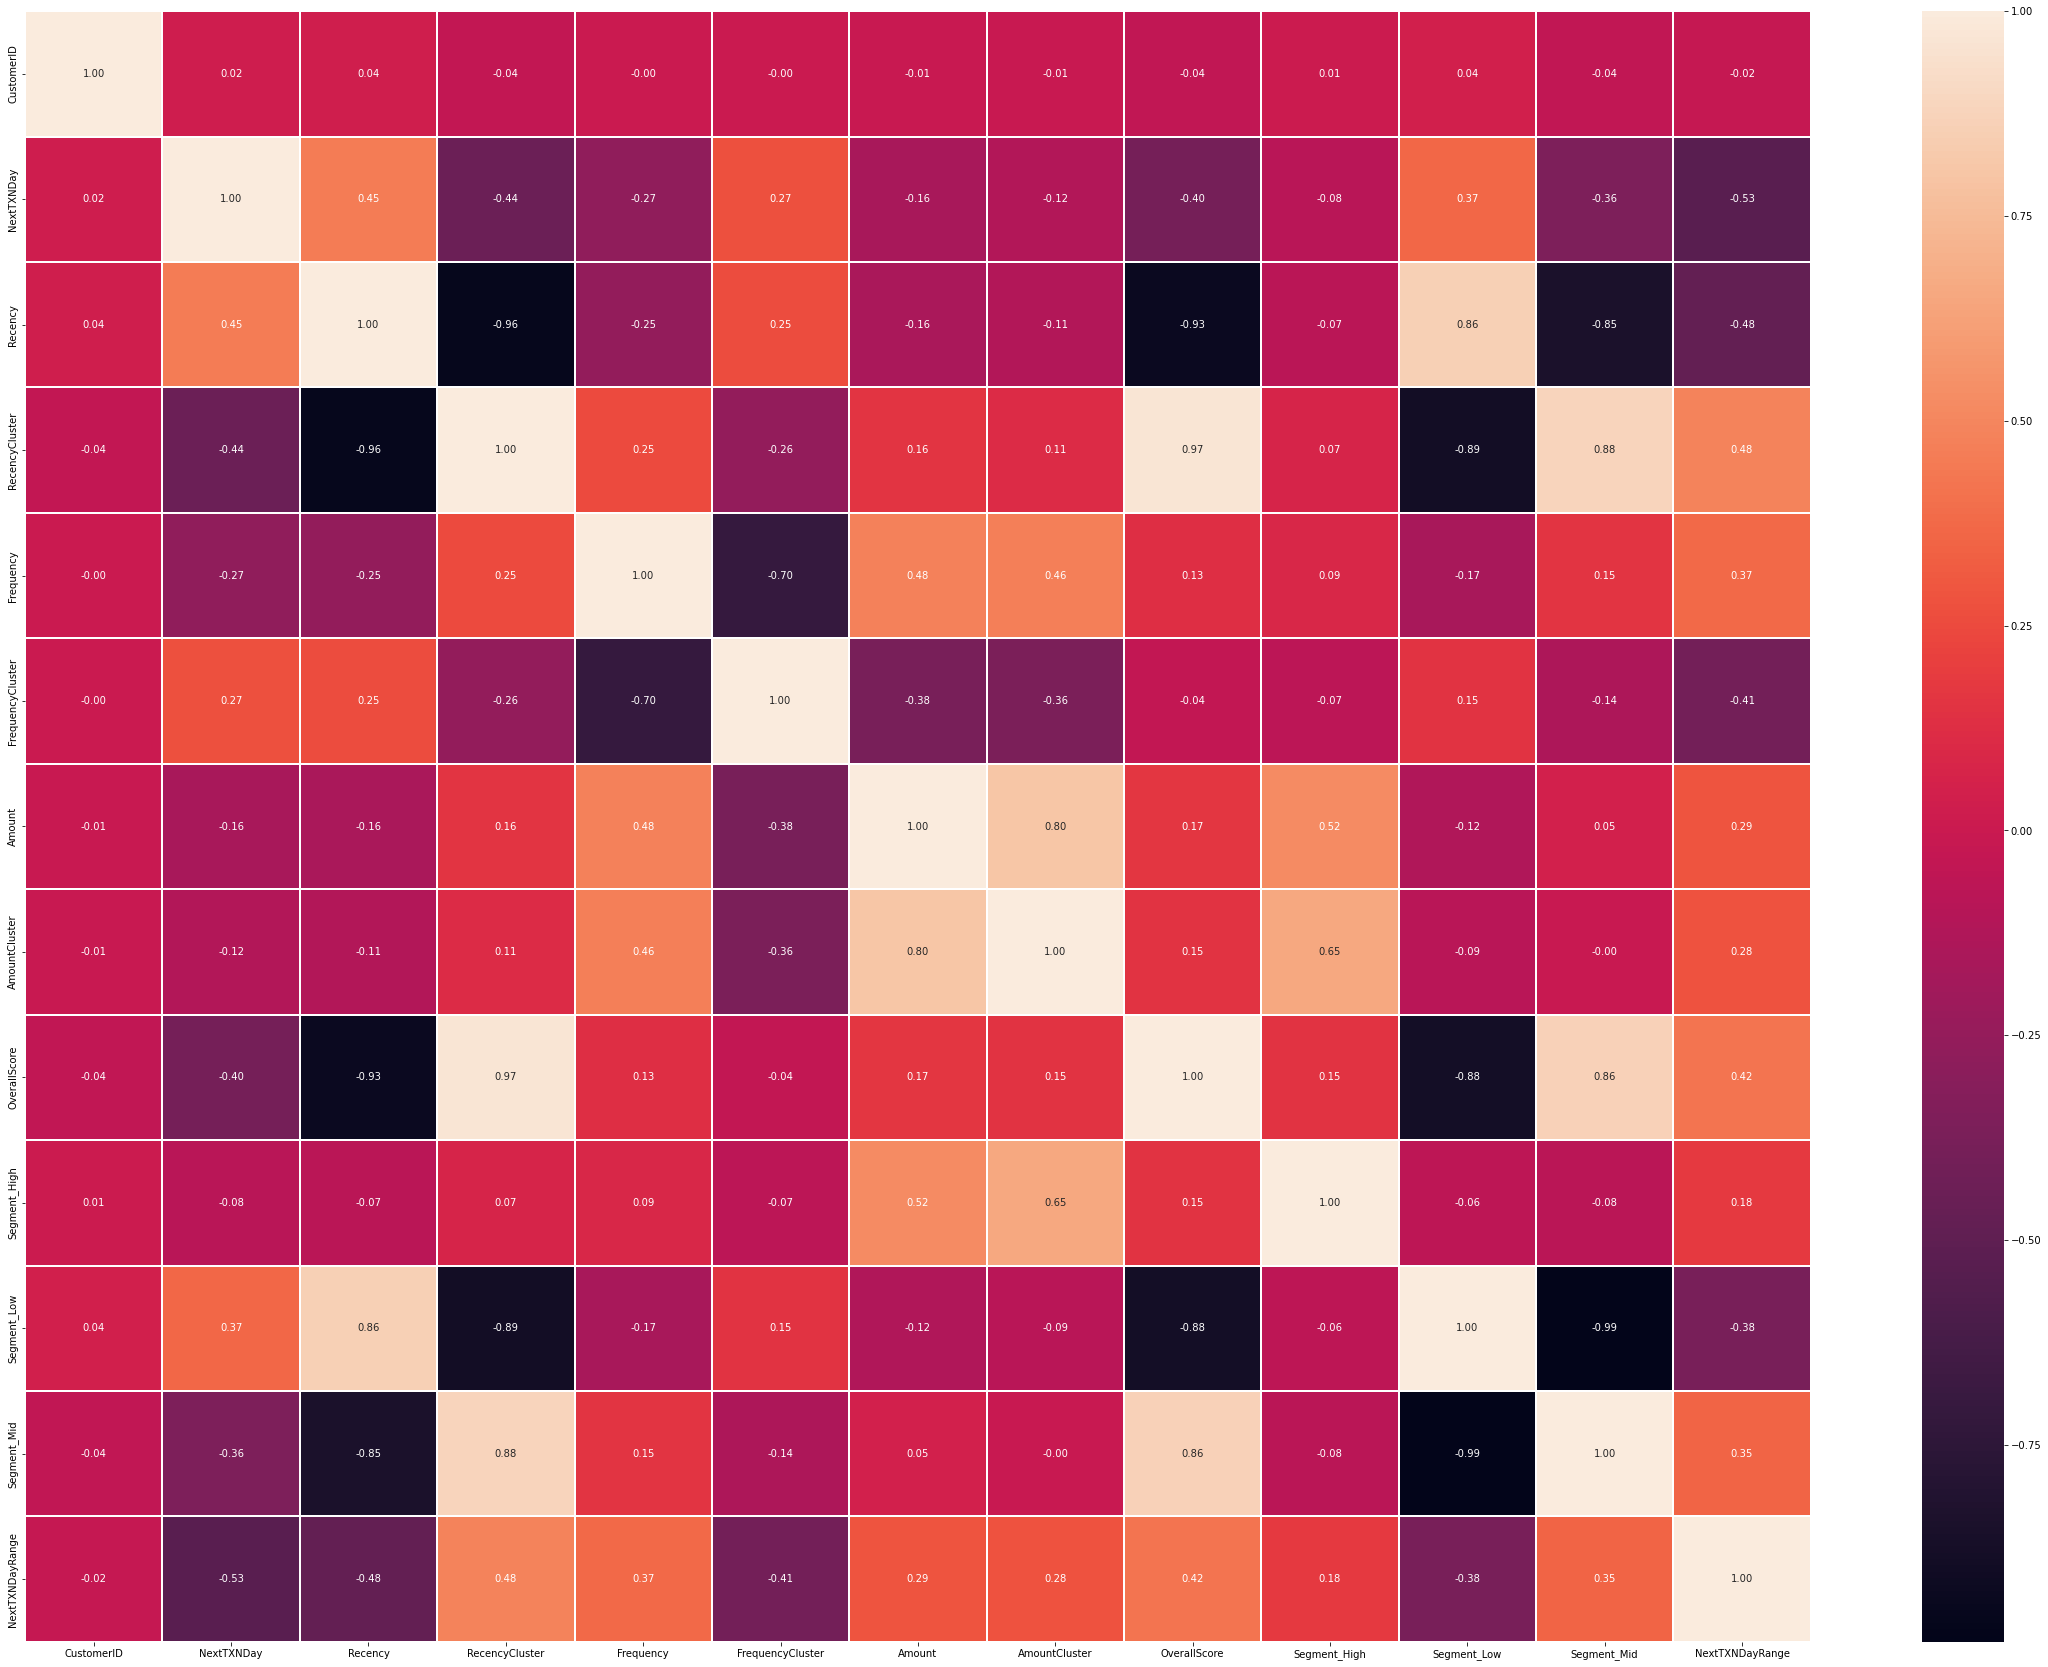

In [36]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

In [37]:
model_data = model_data.drop('NextTXNDay', axis=1)

In [38]:
model_data = model_data.drop('CustomerID', axis=1)

X, y = model_data.drop('NextTXNDayRange', axis=1), model_data.NextTXNDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [39]:
# Create an array of models
models = []
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))

In [40]:
#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, shuffle=True, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

RandomForestClassifier [0.86829727 0.85317647]
SVC [0.82361242 0.81929412]
DecisionTreeClassifier [0.84054563 0.84047059]
xgb.XGBClassifier [0.86594544 0.85082353]


In [41]:


class MultiScorer():
	'''
	Use this class to encapsulate and/or aggregate multiple scoring functions so that it can be passed as an argument for scoring in scikit's cross_val_score function.
	Instances of this class are also callables, with signature as needed by `cross_val_score`.
	'''

	def __init__(self, metrics):
		'''
		Create a new instance of MultiScorer.


		Parameters
		----------
		metrics: dict
			The metrics to be used by the scorer.
			The dictionary must have as key a name (str) for the metric and as value a tuple containing the metric function itself and a dict literal of the additional named arguments to be passed to the function.
			The metric function should be one of the `sklearn.metrics` function or any other callable with the same signature: `metric(y_real, y, **kwargs)`.
		'''

		self.metrics = metrics
		self.results = {}
		self._called = False
		self.n_folds = 0

		for metric in metrics.keys():
			self.results[metric] = []



	def __call__(self, estimator, X, y):
		'''
		To be called by for evaluation from sklearn's GridSearchCV or cross_val_score.
		Parameters are as they are defined in the respective documentation.

		Returns
		-------
			A dummy value of 0.5 just for compatibility reasons.
		'''

		self.n_folds += 1
		yPred = estimator.predict(X)

		for key in self.metrics.keys():
			metric, kwargs = self.metrics[key]

			self.results[key].append(metric(y, yPred, **kwargs))

		self._called = True

		return 0.5

	def get_metric_names(self):
		'''
		Get all the metric names as given when initialized

		Returns
		-------
		A list containing the given names (str) of the metrics
		'''

		return self.metrics.keys()

	def get_results(self, metric=None, fold='all'):
		'''
		Get the results of a specific or all the metrics.
		This method should be called after the object itself has been called so that the metrics are applied.

		Parameters
		----------
		metric: str or None (default)
			The given name of a metric to return its result(s). If omitted the results of all metrics will be returned.

		fold: int in range [1, number_of_folds] or 'all' (Default)
		 	Get the metric(s) results for the specific fold.
			The number of folds corresponds to the number of times the instance is called.
			If its value is a number, either the score of a single metric for that fold or a dictionary of the (single) scores for that fold will be returned, depending on the value of `metric` parameter.
			If its value is 'all', either a list of a single metric or a dictionary containing the lists of scores for all folds will be returned, depending on the value of `metric` parameter.

		Returns
		-------
		metric_result_for_one_fold
			The result of the designated metric function for the specific fold, if `metric` parameter was not omitted and an integer value was given to `fold` parameter.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.

		all_metric_results_for_one_fold: dict
			A dict having as keys the names of the metrics and as values their results for the specific fold.
			This will be returned only if `metric` parameter was omitted and an integer value was given to `fold` parameter.

		metric_results_for_all_folds: list
			A list of length number_of_folds containing the results of all folds for the specific metric, if `metric` parameter was not omitted and value 'all' was given to `fold`.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.

		all_metric_results_for_all_folds: dict of lists
			A dict having as keys the names of the metrics and as values lists (of length number_of_folds) of their results for all folds.
			This will be returned only if `metric` parameter was omitted and 'all' value was given to `fold` parameter.

		Raises
		------
		UserWarning
			If this method is called before the instance is called for evaluation.

		ValueError
			If the value for `fold` parameter is not appropriate.
		'''

		if not self._called:
			raise UserWarning('Evaluation has not been performed yet.')


		if isinstance(fold, str) and fold == 'all':

			if metric is None:
				return self.results
			else:
				return self.results[metric]

		elif isinstance(fold, int):

			if fold not in range(1, self.n_folds+1): raise ValueError('Invalid fold index: '+str(fold))

			if metric is None:
				res = dict()

				for key in self.results.keys():
					res[key] = self.results[key][fold-1]

				return res

			else:
				return self.results[metric][fold-1]
		else:
			raise ValueError('Unexpected fold value: %s' %(str(fold)))


In [42]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
RandomForestClassifier,0.860975,0.652888,0.637550,0.672037,0.479048
xgb.XGBClassifier,0.844449,0.584223,0.570018,0.639934,0.846332
SVC,0.842626,0.543807,0.524377,0.644194,6.582911
DecisionTreeClassifier,0.840431,0.564952,0.550420,0.634007,0.020998


In [43]:
log_reg_pred_y = LogisticRegression().fit(X_train, y_train).predict(X_test)

In [44]:
ran_for_pred_y = RandomForestClassifier().fit(X_train, y_train).predict(X_test)

In [45]:
xgb_pred_y = xgb.XGBClassifier().fit(X_train, y_train).predict(X_test)

In [46]:
import matplotlib.cm as cm
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=cm.gray)
    plt.show()

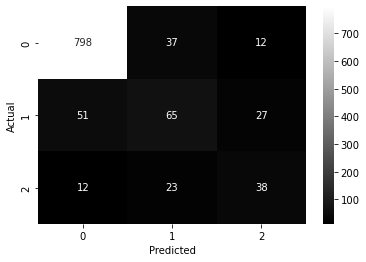

In [47]:
get_confusion_matrix(np.array(y_test), ran_for_pred_y)

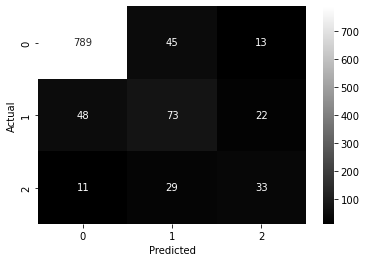

In [48]:
get_confusion_matrix(np.array(y_test), xgb_pred_y)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), ran_for_pred_y))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       847
           1       0.52      0.45      0.49       143
           2       0.49      0.52      0.51        73

    accuracy                           0.85      1063
   macro avg       0.65      0.64      0.64      1063
weighted avg       0.84      0.85      0.84      1063



In [50]:
print(classification_report(np.array(y_test), xgb_pred_y))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       847
           1       0.50      0.51      0.50       143
           2       0.49      0.45      0.47        73

    accuracy                           0.84      1063
   macro avg       0.64      0.63      0.63      1063
weighted avg       0.84      0.84      0.84      1063

